In [1]:
import sys
import numpy as np
import torch
sys.path.append("../../Work/Repos/pydens/pydens/")

## Importing `solver` and tokens

In [2]:
from model_torch import Solver, D, V

## Simple ODE

In [3]:
def ode(f, x):
    return D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)

In [4]:
solver = Solver(ode, ndims=1, initial_condition=.5)

In [5]:
solver.fit(niters=1500, batch_size=400)

100%|██████████| 1500/1500 [00:02<00:00, 502.26it/s]


In [6]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
approxs = solver.model(xs)

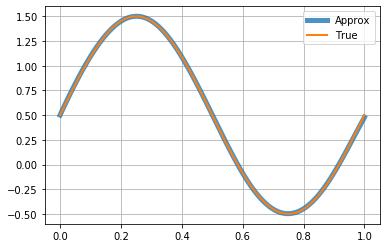

In [11]:
import matplotlib.pyplot as plt
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + .5,
         label='True', linewidth=2)
plt.grid()
plt.legend()

## Simple PDE

In [8]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

In [9]:
solver = Solver(pde, ndims=2, boundary_condition=1)

In [10]:
solver.fit(niters=3500, batch_size=400)

100%|██████████| 3500/3500 [00:24<00:00, 141.93it/s]


In [12]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

In [13]:
grid = cart_prod(np.linspace(0, 1, 100),
                 np.linspace(0, 1, 100))

In [14]:
approxs = solver.model(torch.tensor(grid[:, 0:1]).float(),
                       torch.tensor(grid[:, 1:2]).float())

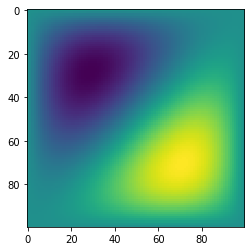

In [15]:
plt.imshow(approxs.reshape((100, 100)).detach().numpy())

## Parametric family of ODEs

In [16]:
def odeparam(f, x, e):
    return D(f, x) - e * np.pi * torch.cos(e * np.pi * x)

In [17]:
solver = Solver(odeparam, ndims=1, initial_condition=2, nparams=1)

In [18]:
solver.fit(niters=5000, batch_size=400)

100%|██████████| 5000/5000 [00:10<00:00, 480.94it/s]


In [19]:
# checking out the solution approximation for fixed epsilon
eps = 0.9
approxs = solver.model(xs, torch.ones_like(xs) * eps)
true = np.sin(eps * np.pi * xs.numpy()) + 2

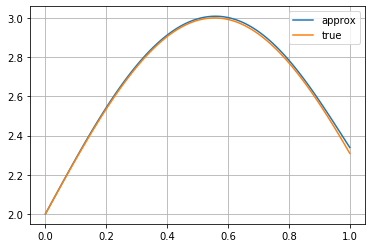

In [20]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='approx')
plt.plot(xs.detach().numpy(), true, label='true')
plt.grid()
plt.legend()

In [ ]:
# missing
# samplers are hard-coded now: need to add capability to control them
# perhaps add capability to fix the parameter

## ODE with trainable coefficients

In [3]:
def odevar(f, x):
    return (D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)
            + V('new_var', data=torch.Tensor([1.0]), requires_grad=True))

In [4]:
solver = Solver(odevar, ndims=1, initial_condition=1,
                constraints=lambda f, x: f(torch.tensor([0.5])))

* learning to solve the equation with fixed value of the variable

In [6]:
solver.model.freeze_layers(variables=('new_var',))

In [7]:
solver.fit(niters=2000, batch_size=400)

100%|██████████| 2000/2000 [00:04<00:00, 479.69it/s]


In [24]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
approxs = solver.model(xs)

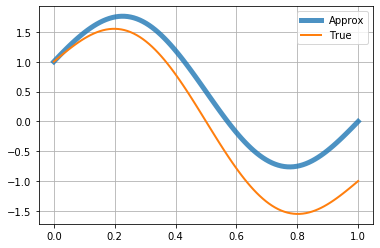

In [11]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + 1 - 
         2* xs.detach().numpy(),
         label='True', linewidth=2)
plt.grid()
plt.legend()

* the additional constraint isn't satisfied - let's fix it

In [12]:
solver.model.unfreeze_layers(variables=['new_var'])

In [17]:
solver.fit(niters=1500, batch_size=400, losses=['equation', 'constraint_0'])

100%|██████████| 500/500 [00:01<00:00, 354.44it/s]


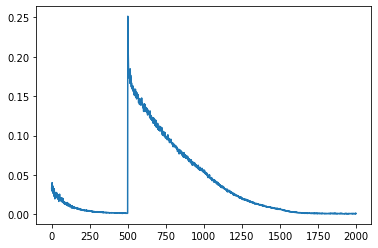

In [22]:
plt.plot(solver.losses[1500:])

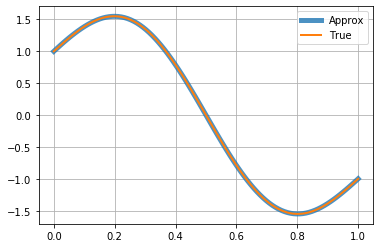

In [25]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + 1 - 
         2* xs.detach().numpy(),
         label='True', linewidth=2)
plt.grid()
plt.legend()

* cool, everything is now satisfied